<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/Tyler_Sanjay_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 11.4 MB/s eta 0:00:00


In [2]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

In [4]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In your google drive, there should be a `chembl_33_data.tar.gz` file. Locate that in the files tab on the left and copy and paste it's path into the line below.

 ### e.g. If the file pathway is `/content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz` the the code below will look this this:

 ### `!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/`

In [5]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [6]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei,molecule_drawing
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,1.100000e+02,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN,
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,7.307800e+04,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06,
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,3.000000e+01,nM,156048,11934,CHEMBL3213,Homo sapiens,...,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60,
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,9.500000e+01,nM,156048,11934,CHEMBL3213,Homo sapiens,...,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70,
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,1.900000e+02,nM,156048,11934,CHEMBL3213,Homo sapiens,...,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,169,CCCCCC(=O)OCC1CN(C(=O)c2cc(OC)c(OC)c(OC)c2)CCN...,69964,IC50,2.900000e+02,nM,164922,10014,CHEMBL5136,Cavia porcellus,...,602.2839,12.0,0.0,2.0,-0.38,NaN,NaN,NaN,NaN,
96,170,Cc1nccn1CCCCc1ccc(CC(=O)N[C@H](CO)Cc2ccc(OCCC3...,658970,IC50,6.230000e+04,nM,141302,104853,CHEMBL366,Homo sapiens,...,588.4039,7.0,4.0,2.0,-0.49,7.70,0.14,-1.19,4.43,
97,171,COc1cc(C(=O)N2CCN(C(=O)c3cc(OC)c(OC)c(OC)c3)C(...,67493,IC50,1.000000e+05,nM,164922,50607,CHEMBL5136,Oryctolagus cuniculus,...,588.2683,12.0,0.0,2.0,-0.45,11.08,0.21,3.23,5.33,
98,173,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,24969005,Solubility,1.513561e+13,nM,2262703,119104,CHEMBL6174,Trypanosoma cruzi,...,357.0768,5.0,1.0,0.0,-0.72,27.54,0.54,5.92,14.38,

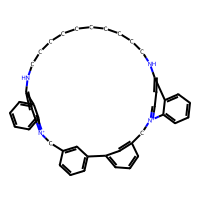
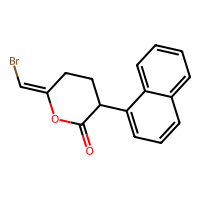
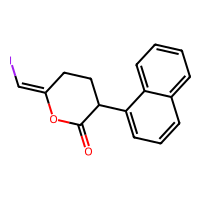
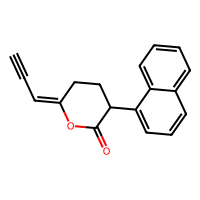
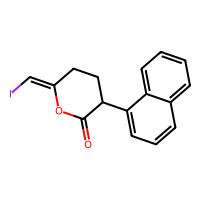
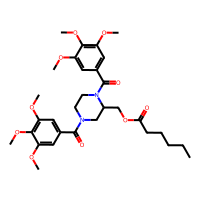
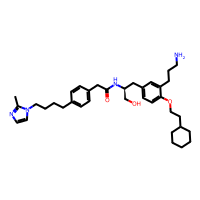
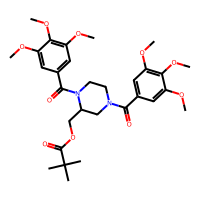
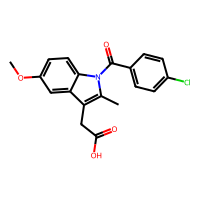
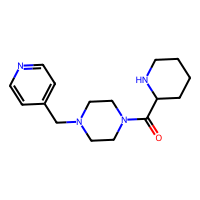

In [7]:
df_small = df.head(100).copy()
PandasTools.AddMoleculeColumnToFrame(df_small, smilesCol = 'canonical_smiles', molCol = 'molecule_drawing')
df_small

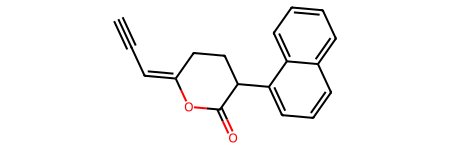

In [8]:
df_new = df_small.canonical_smiles.iloc[3]
Chem.MolFromSmiles(df_new)

In [9]:
print(Chem.MolToMolBlock(Chem.MolFromSmiles(df_new)))


     RDKit          2D

 20 22  0  0  0  0  0  0  0  0999 V2000
   -9.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -8.2500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -7.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -6.0000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.2500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0

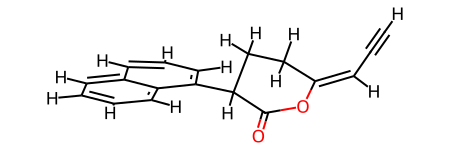

In [10]:
from rdkit.Chem import AllChem
df_newwithH = Chem.AddHs(Chem.MolFromSmiles(df_new, sanitize = True))
AllChem.EmbedMolecule(df_newwithH)
df_newwithH.GetNumAtoms()
AllChem.MMFFOptimizeMolecule(df_newwithH)
df_newwithH

In [11]:
print(Chem.MolToMolBlock(df_newwithH))


     RDKit          3D

 34 36  0  0  0  0  0  0  0  0999 V2000
    5.7525    1.5519    2.5164 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.2602    0.8583    1.6693 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.6896    0.0334    0.6633 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3694   -0.1380    0.4964 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.3004    0.5232    1.3118 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.0826    0.7935    0.4496 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5778   -0.5196   -0.1463 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7178   -0.2461   -0.9194 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6288    0.2160   -2.2489 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7695    0.4985   -2.9909 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0246    0.3413   -2.4161 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.1595   -0.0888   -1.0898 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.4437   -0.2194   -0.5354 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.6200   -0.6283    0

In [12]:
df['num_lipinski_ro5_violations']

0         2.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
999995    2.0
999996    2.0
999997    1.0
999998    1.0
999999    1.0
Name: num_lipinski_ro5_violations, Length: 1000000, dtype: float64

In [13]:
new_df = df[df['num_lipinski_ro5_violations'] < 1]

In [14]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

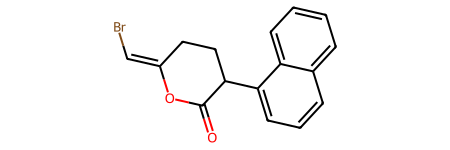

In [15]:
Chem.MolFromSmiles(df['canonical_smiles'].iloc[1])

In [16]:
(new_df['canonical_smiles'].iloc[0])

'O=C1O/C(=C/Br)CCC1c1cccc2ccccc12'

In [17]:
new_df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

In [18]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

In [19]:
wanted_values = ['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50']
wanted_values

['Potency',
 'IC50',
 'Kd',
 'Ki',
 'Solubility',
 'Km',
 'MIC',
 'XC50',
 'Selectivity',
 'Cmax',
 'MIC80',
 'MIC50',
 'Kp',
 'LC50',
 'Kinact',
 'GI50',
 'MCC',
 'CC50',
 'Kb',
 'pKi',
 'TGI',
 'pA2',
 'IC95',
 'TC50',
 'EC50',
 'Inhibition',
 'ID50',
 'fCmax',
 'Ratio',
 'IC90',
 'AC50']

In [20]:
new_df[new_df['standard_type'] == 'Potency']


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,7.307800e+04,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
53,111,Cc1cc(CC(=O)[O-])n(C)c1C(=O)c1ccc(Cl)cc1.[Na+],15598675,Potency,1.000000e+05,nM,1495415,103989,CHEMBL612545,Plasmodium falciparum,...,0.88,291.0662,4.0,1.0,0.0,-0.65,17.48,0.35,2.25,8.60
56,115,CN1CCC[C@H]1c1cccnc1,22970864,Potency,4.570882e+08,nM,2089382,118698,CHEMBL614818,Torpedo californica,...,0.63,162.1157,2.0,0.0,0.0,-0.41,67.80,1.25,9.15,68.20
75,146,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,24958979,Potency,3.367000e+07,nM,2260153,118698,CHEMBL615052,Trypanosoma brucei brucei,...,0.87,361.1438,7.0,1.0,0.0,-0.21,16.12,0.31,4.28,7.76
76,147,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,24813526,Potency,1.760000e+07,nM,2224252,118698,CHEMBL615022,Streptococcus pyogenes,...,0.85,232.0848,5.0,1.0,0.0,-0.98,18.41,0.34,2.86,5.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997571,1510946,O=[N+]([O-])c1ccccc1/C=N/N1CCN(Cc2ccccc2)CC1,15478361,Potency,8.912510e+04,nM,1495346,104016,CHEMBL612545,Plasmodium falciparum,...,0.48,324.1586,6.0,0.0,0.0,-1.68,NaN,NaN,NaN,NaN
997572,1510947,C/C(=N\N1CCN(Cc2ccccc2Cl)CC1)c1ccc([N+](=O)[O-...,15570211,Potency,4.200000e+05,nM,1495346,104016,CHEMBL614818,Plasmodium falciparum,...,0.45,372.1353,6.0,0.0,0.0,-1.80,13.14,0.26,1.11,7.91
997574,1510949,Cn1cccc1/C=N/N1CCN(Cc2ccccc2)CC1,12627584,Potency,1.000000e+05,nM,937879,105144,CHEMBL612545,Trypanosoma brucei brucei (strain 927/4 GUTat1...,...,0.80,282.1844,4.0,0.0,0.0,-1.62,19.48,0.36,3.32,23.14
997747,1511168,COc1ccc(C(CC(=O)N2CCCC2)c2c(O)cc(OC)cc2OC)cc1,12986917,Potency,2.909290e+04,nM,954305,103069,CHEMBL1075138,Homo sapiens,...,0.79,385.1889,6.0,1.0,0.0,-0.18,NaN,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei,molecule_drawing
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0000,nM,156048,11934,CHEMBL3213,Homo sapiens,...,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70,
5,31,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,325753,IC50,0.5129,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,433.2114,8.0,2.0,0.0,-0.89,21.43,0.40,6.61,9.90,
6,33,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,343861,IC50,33.8800,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,435.1035,9.0,2.0,0.0,-1.78,17.15,0.35,5.67,6.74,
20,59,COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC,331005,IC50,3.3880,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,421.2114,8.0,2.0,0.0,-0.91,20.10,0.37,5.96,9.03,
21,60,COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...,331003,IC50,3.3880,nM,33574,104304,CHEMBL1907610,Rattus norvegicus,...,449.2063,9.0,2.0,0.0,-0.67,18.84,0.35,5.87,8.22,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999987,1513841,Cc1cc2c(N3CCNCC3)nc(N)nc2[nH]1,12634097,Ki,2670.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,232.1436,6.0,4.0,0.0,-0.98,23.99,0.45,5.31,6.73,
999988,1513842,Nc1nc(N2CCNCC2)c2cc(-c3ccccc3)[nH]c2n1,12634096,Ki,1410.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,294.1593,6.0,4.0,0.0,-0.82,19.88,0.36,4.23,7.06,
999989,1513843,CN1CCN(c2nc(N)nc3[nH]c(-c4ccccc4)cc23)CC1,12634095,Ki,5400.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,308.1749,6.0,3.0,0.0,-0.98,17.08,0.31,3.31,7.11,
999990,1513844,CN1CCN(c2nc(N)nc3[nH]c(-c4ccc(F)cc4)cc23)CC1,12634094,Ki,2640.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,326.1655,6.0,3.0,0.0,-1.24,17.09,0.32,3.48,7.53,

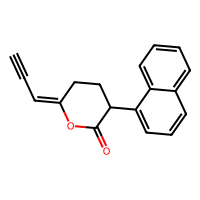
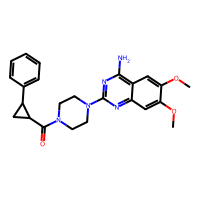
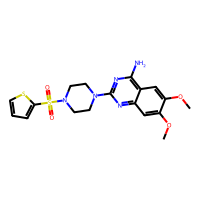
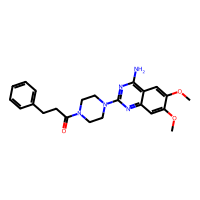
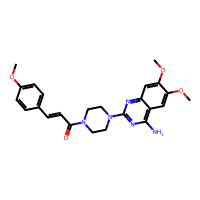
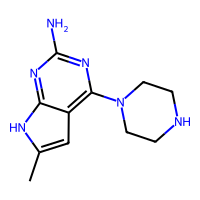
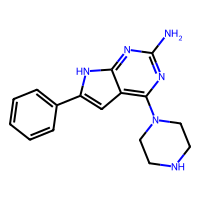
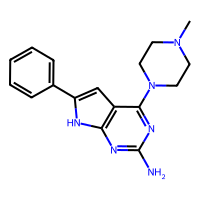
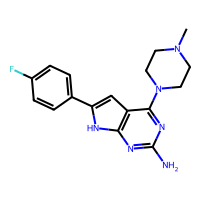
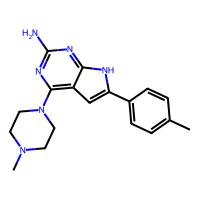

In [21]:
lip_df = new_df[(new_df['num_lipinski_ro5_violations'] == 0) & (new_df['hba_lipinski'] <= 10) & (new_df['mw_monoisotopic'] < 480) & (new_df['le']>0.3) & (new_df['lle']>3)]
PandasTools.AddMoleculeColumnToFrame(lip_df, smilesCol = 'canonical_smiles', molCol = 'molecule_drawing')
lip_df


In [22]:
lip_df['canonical_smiles'].iloc[0]

'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1'

In [23]:
1+1

2

In [24]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

smiles_list = list(lip_df['canonical_smiles'].iloc[:10].values)
vocab = sorted(list(set("".join(smiles_list))))
chars_to_index = {char:index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}
print(len(vocab))

def oneHotEncode(smiles, char_to_index, maxlen):
  encoded = [chars_to_index[char] for char in smiles]
  padded = pad_sequences([encoded], maxlen = maxlen, padding = 'post', truncating='post')[0]
  ohe = to_categorical(padded, num_classes = len(vocab))
  return ohe
maxLength = max(len(smiles) for smiles in smiles_list)
x = np.array([oneHotEncode(smiles, chars_to_index, maxLength) for smiles in smiles_list])
print(maxLength)
print(x.shape)
print(type(x))

19
57
(10, 57, 19)
<class 'numpy.ndarray'>


In [25]:
x[0].shape

(57, 19)

In [26]:
#Data preparation

class SmilesDataSet:
  def __init__(self, smiles_list):
    self.smiles_list = smiles_list
    self.chars = sorted(list(set("".join(smiles_list))))
    self.chars_to_index = {char:index for index, char in enumerate(self.chars)}
    self.index_to_chars = {index: char for index, char in enumerate(self.chars)}
    self.vocab_size = len(self.chars)
    self.max_length = max(len(smiles) for smiles in smiles_list)

  def encode_smiles(self, smiles):
    return [self.chars_to_index[chars] for chars in smiles]
dataSet = SmilesDataSet(["c", "cc", "abcdef", "hijkl", "191"])
dataSet.encode_smiles("abcdef")

[2, 3, 4, 5, 6, 7]

In [27]:
dataSet.max_length

6

In [28]:
len(lip_df)

118542

In [29]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Activation, MultiHeadAttention, LayerNormalization, Dropout, Input
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Model
from rdkit import RDLogger
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [30]:

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# # Re-enable RDKit warnings if needed
# RDLogger.EnableLog('rdApp.*')

# Function to decode one-hot encoded sequences to SMILES strings
def decode_sequence(one_hot_seq):
    decoded = ""
    for time_step in one_hot_seq:
        char_index = np.argmax(time_step)
        decoded += index_to_chars[char_index]
    return decoded

def strip_special_tokens(decoded_seq):
    return decoded_seq.replace('<PAD>', '').replace('<EOS>', '')

def create_smiles_table(smiles_string, vocab_len):
    encoded_smiles = np.zeros((len(smiles_string), vocab_len))
    for i, char in enumerate(smiles_string):
        if char in chars_to_index:
            encoded_smiles[i, chars_to_index[char]] = 1
    return encoded_smiles

# Function to check the validity of generated SMILES strings using RDKit
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles, max_tokens=100):
    # Encode the seed SMILES string
    encoded_smiles = create_smiles_table(seed_smiles, len(vocab))
    encoded_smiles = pad_sequences([encoded_smiles], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    # Generate SMILES string
    generated_smiles = seed_smiles
    for _ in range(max_tokens):
        prediction = model.predict(encoded_smiles, verbose=0)[0]
        next_char_index = np.argmax(prediction[len(generated_smiles)-1])
        next_char = index_to_chars[next_char_index]
        if next_char == '<EOS>':
            break
        generated_smiles += next_char
        if len(generated_smiles) >= max_length:
            break
        encoded_smiles = create_smiles_table(generated_smiles, len(vocab))
        encoded_smiles = pad_sequences([encoded_smiles], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    return generated_smiles

# Generate a set of SMILES strings using the trained model
def generate_smiles_samples(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles, num_samples=100):
    generated_smiles_list = []
    for _ in range(num_samples):
        generated_smiles = generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles)
        generated_smiles_list.append(generated_smiles)
    return generated_smiles_list

# Function to evaluate generated SMILES strings
def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):

    valid_count = 0
    novel_count = 0
    valid_novel_smiles = set()

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles):
            valid_count += 1
            if smiles not in training_smiles_list:
                novel_count += 1
                valid_novel_smiles.add(smiles)

    validity = valid_count / len(generated_smiles_list) * 100
    uniqueness = len(valid_novel_smiles) / len(generated_smiles_list) * 100
    novelty = novel_count / len(generated_smiles_list) * 100

    return validity, uniqueness, novelty, list(valid_novel_smiles)


In [31]:
# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Create vocabulary from SMILES list
vocab = sorted(list(set("".join(smiles_list))))

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<EOS>']
vocab = special_tokens + vocab  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 1 for the <EOS> token)
max_length = max(len(smiles) for smiles in smiles_list) + 1

# Encode all SMILES strings
encoded_smiles_list = [create_smiles_table(s, len(vocab)) for s in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

vocabulary: ['<PAD>', '<EOS>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '=', '@', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'S', '[', '\\', ']', 'a', 'c', 'i', 'l', 'n', 'o', 'r', 's']
Number of smiles strings: 10000
vocabulary length: 39
Max Length: 98
Padded smiles list shape: (10000, 98, 39)


In [32]:
# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros((X.shape[0], X.shape[1], len(vocab)))
for i, seq in enumerate(X):
    y[i, :-1, :] = seq[1:, :]  # Shifted by one time step
    y[i, -1, chars_to_index['<EOS>']] = 1  # Last step as <EOS>

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize 10 samples of X and y
for i in range(1):
    print(f"Sample {i+1}:")
    print("X padded:", decode_sequence(X[i]))
    print("y padded:", decode_sequence(y[i]))
    print("X:", strip_special_tokens(decode_sequence(X[i])))
    print("y:", strip_special_tokens(decode_sequence(y[i])))
    print()

Sample 1:
X padded: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
y padded: #C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><EOS>
X: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1
y: #C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1



In [33]:
MODEL_DIM = 256
EPOCHS = 150
BATCH_SIZE = 64
DROPOUT = 0.1
NUM_HEADS = 4
LEARNING_RATE = 1e-3

# Build the model with self-attention
input_layer = Input(shape=(max_length, len(vocab)))
lstm_layer = LSTM(MODEL_DIM, return_sequences=True)(input_layer)
attention_layer = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=MODEL_DIM)(lstm_layer, lstm_layer)
norm_layer = LayerNormalization(epsilon=1e-6)(attention_layer + lstm_layer)
dropout_layer = Dropout(DROPOUT)(norm_layer)
output_layer = TimeDistributed(Dense(len(vocab), activation='softmax'))(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and include validation data
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/150
125/125 [==============================] - 13s 38ms/step - loss: 0.6616 - accuracy: 0.2045 - val_loss: 0.4853 - val_accuracy: 0.2435
Epoch 2/150
125/125 [==============================] - 4s 35ms/step - loss: 0.4552 - accuracy: 0.2525 - val_loss: 0.3900 - val_accuracy: 0.2730
Epoch 3/150
125/125 [==============================] - 4s 36ms/step - loss: 0.3615 - accuracy: 0.2834 - val_loss: 0.3000 - val_accuracy: 0.3017
Epoch 4/150
125/125 [==============================] - 4s 32ms/step - loss: 0.1510 - accuracy: 0.3561 - val_loss: 0.0388 - val_accuracy: 0.3959
Epoch 5/150
125/125 [==============================] - 4s 32ms/step - loss: 0.0313 - accuracy: 0.3994 - val_loss: 0.0100 - val_accuracy: 0.4047
Epoch 6/150
125/125 [==============================] - 4s 35ms/step - loss: 0.0054 - accuracy: 0.4078 - val_loss: 0.0024 - val_accuracy: 0.4068
Epoch 7/150
125/125 [==============================] - 4s 36ms/step - loss: 0.0021 - accuracy: 0.4085 - val_loss: 0.0014 - val_accuracy

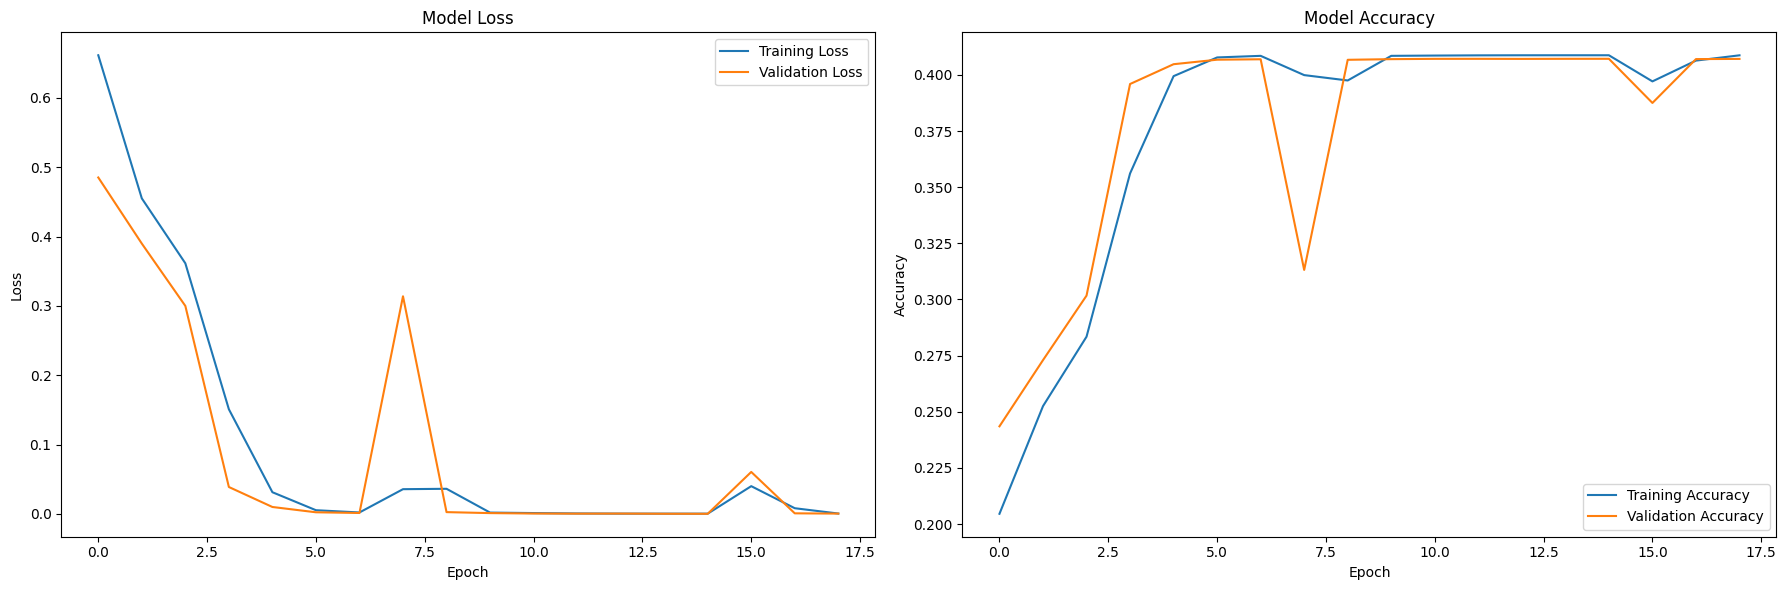

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [35]:
# Example usage
seed_smiles = "C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1"  # Use a starting seed SMILES string
seed_smile = ""
seed_smiles_list = []
for char in seed_smiles:
  seed_smile += char
  seed_smiles_list.append(seed_smile)

generated_smiles_list = []
i = 1
for smiles_string in tqdm(seed_smiles_list):

  generated_smiles = generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, smiles_string, max_tokens=len(seed_smiles) - i)
  generated_smiles_list.append(generated_smiles)
  i += 1


100%|██████████| 35/35 [00:37<00:00,  1.07s/it]


In [36]:
seed_smiles_list

['C',
 'C#',
 'C#C',
 'C#C/',
 'C#C/C',
 'C#C/C=',
 'C#C/C=C',
 'C#C/C=C1',
 'C#C/C=C1\\',
 'C#C/C=C1\\C',
 'C#C/C=C1\\CC',
 'C#C/C=C1\\CCC',
 'C#C/C=C1\\CCC(',
 'C#C/C=C1\\CCC(c',
 'C#C/C=C1\\CCC(c2',
 'C#C/C=C1\\CCC(c2c',
 'C#C/C=C1\\CCC(c2cc',
 'C#C/C=C1\\CCC(c2ccc',
 'C#C/C=C1\\CCC(c2cccc',
 'C#C/C=C1\\CCC(c2cccc3',
 'C#C/C=C1\\CCC(c2cccc3c',
 'C#C/C=C1\\CCC(c2cccc3cc',
 'C#C/C=C1\\CCC(c2cccc3ccc',
 'C#C/C=C1\\CCC(c2cccc3cccc',
 'C#C/C=C1\\CCC(c2cccc3ccccc',
 'C#C/C=C1\\CCC(c2cccc3ccccc2',
 'C#C/C=C1\\CCC(c2cccc3ccccc23',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1']

In [37]:
validity, uniqueness, novelty, unique_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"Percent valid: {validity}")
print(f"Percent unique: {uniqueness}")
print(f"Percent novel: {novelty}")
print(unique_smiles)

Percent valid: 14.285714285714285
Percent unique: 5.714285714285714
Percent novel: 11.428571428571429
['C#CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'C#C/C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCC']


Epoch 1/150
125/125 [==============================] - 17s 79ms/step - loss: 0.5943 - accuracy: 0.2266 - val_loss: 0.3955 - val_accuracy: 0.2785
Epoch 2/150
125/125 [==============================] - 9s 71ms/step - loss: 0.3537 - accuracy: 0.2909 - val_loss: 0.3022 - val_accuracy: 0.3054
Epoch 3/150
125/125 [==============================] - 9s 71ms/step - loss: 0.2854 - accuracy: 0.3116 - val_loss: 0.2527 - val_accuracy: 0.3209
Epoch 4/150
125/125 [==============================] - 9s 72ms/step - loss: 0.2406 - accuracy: 0.3263 - val_loss: 0.2171 - val_accuracy: 0.3321
Epoch 5/150
125/125 [==============================] - 9s 70ms/step - loss: 0.2019 - accuracy: 0.3387 - val_loss: 0.1760 - val_accuracy: 0.3465
Epoch 6/150
125/125 [==============================] - 9s 70ms/step - loss: 0.1435 - accuracy: 0.3589 - val_loss: 0.0910 - val_accuracy: 0.3765
Epoch 7/150
125/125 [==============================] - 9s 73ms/step - loss: 0.0555 - accuracy: 0.3909 - val_loss: 0.0206 - val_accuracy

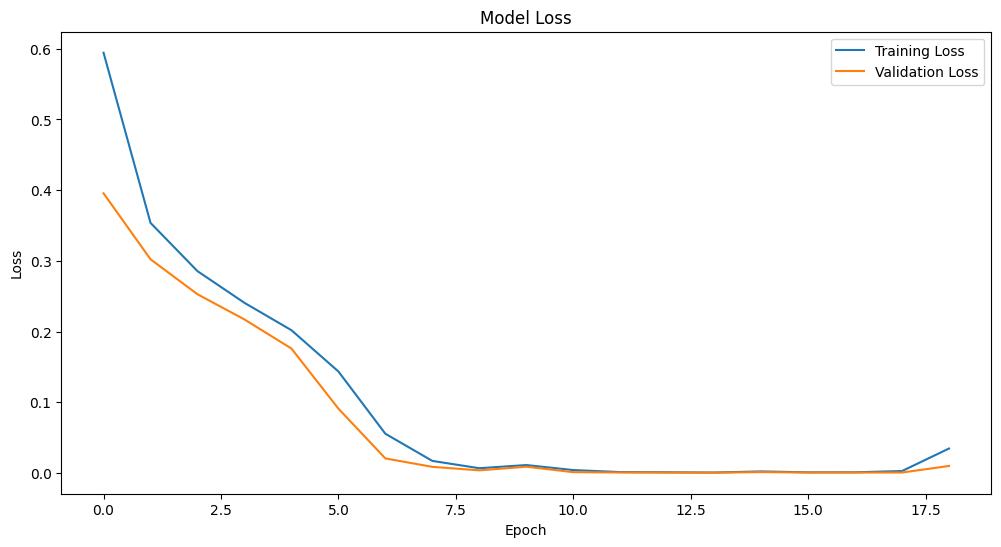

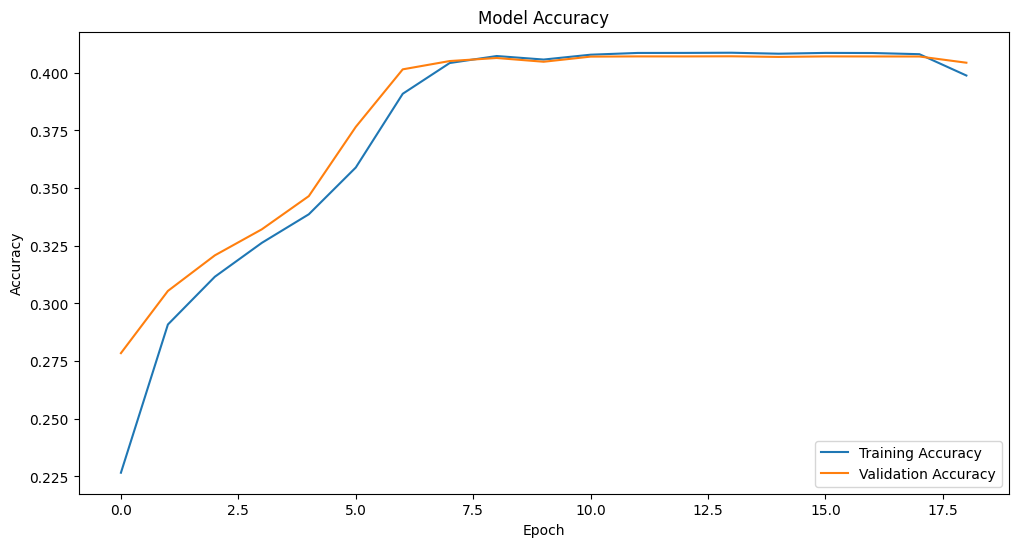

In [38]:
MODEL_DIM = 256
EPOCHS = 150
BATCH_SIZE = 64
DROPOUT = 0.1
NUM_HEADS = 8
LEARNING_RATE = 1e-3


# Build the model with self-attention and additional dropout
input_layer = Input(shape=(max_length, len(vocab)))
lstm_layer = LSTM(MODEL_DIM, return_sequences=True)(input_layer)
attention_layer = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=MODEL_DIM)(lstm_layer, lstm_layer)
norm_layer = LayerNormalization(epsilon=1e-6)(attention_layer + lstm_layer)
dropout_layer1 = Dropout(DROPOUT)(norm_layer)
lstm_layer2 = LSTM(MODEL_DIM, return_sequences=True)(dropout_layer1)
dropout_layer2 = Dropout(DROPOUT)(lstm_layer2)
output_layer = TimeDistributed(Dense(len(vocab), activation='softmax'))(dropout_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [39]:
seed_smiles = "C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1"  # Use a starting seed SMILES string
seed_smile = ""
seed_smiles_list = []
for char in seed_smiles:
  seed_smile += char
  seed_smiles_list.append(seed_smile)

generated_smiles_list = []
i = 1
for smiles_string in tqdm(seed_smiles_list):

  generated_smiles = generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, smiles_string, max_tokens=len(seed_smiles) - i)
  generated_smiles_list.append(generated_smiles)
  i += 1

validity, uniqueness, novelty, unique_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"Percent valid: {validity}")
print(f"Percent unique: {uniqueness}")
print(f"Percent novel: {novelty}")
print(unique_smiles)

100%|██████████| 35/35 [00:40<00:00,  1.16s/it]

Percent valid: 2.857142857142857
Percent unique: 0.0
Percent novel: 0.0
[]
